   - 학습 데이터 (user_id : 10000 ~ 24999, 15000명)


			- train_err_data.csv : 시스템에 발생한 에러 로그

			- train_quality_data.csv : 시스템 퀄리티 로그

			- train_problem_data.csv : 사용자 불만 및 불만이 접수된 시간


   - 테스트 데이터(user_id : 30000 ~ 44998, 14999명)


			- test_err_data.csv : 시스템에 발생한 에러 로그

			- test_quality_data.csv : 시스템 퀄리티 로그

			- sample_submission.csv : 사용자 불만 확률(0~1) (제출용)

## 사용할 Module & Data 불러오기 

In [119]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score ,f1_score, roc_auc_score, precision_recall_curve , auc
from sklearn.model_selection import KFold
from xgboost import plot_importance ## Feature Importance 를 불러오기 위함이다
import missingno as msno
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
PATH = '../data/'
train_err =pd.read_csv(PATH+'train_err.csv')
train_problem =pd.read_csv(PATH+'train_problem.csv')
train_quality =pd.read_csv(PATH+'train_quality.csv')
test_err = pd.read_csv(PATH+'test_err.csv')
test_quality = pd.read_csv(PATH+'test_quality.csv')


# err data 는 user_id 15000 명의 대한것이다

### time datetime으로 바꾸기

In [3]:
# time 을 datetime 타입으로 바꾸고 바뀐지 확인
# train_err.info()
# test_err.info()
# test_quality.info()
# train_quality.info()
# train_problem.info()
# train_problem.time = train_problem.time.map(make_datetime)
# train_quality.time = train_quality.time.map(make_datetime)
# test_quality.time = test_quality.time.map(make_datetime)

In [14]:
# 바꾼 csv 저장

# train_quality.to_csv('../data/train_quality.csv')
# train_problem.to_csv('../data/train_problem.csv')
# test_quality.to_csv('../data/test_quality.csv')


In [3]:
# time 을 datetime 타입으로 바꾸고 바뀐지 확인
train_quality.time = pd.to_datetime(train_quality.time)
test_err.time = pd.to_datetime(test_err.time)
train_problem.time = pd.to_datetime( train_problem.time)
train_err.time = pd.to_datetime(train_err.time)
test_quality.time = pd.to_datetime(test_quality.time)


In [12]:
# pd.to_datetime(train_err_df.time)
# pd.set_option('display.max_rows)
# pandas display 할때 보여주는 최대 로우수와 컬럼수 지정  
pd.options.display.max_rows = 100
pd.options.display.max_columns = 30

In [ ]:
def make_datetime(x):
    x = str(x)
    year = int(x[:4])
    month = int(x[4:6])
    day = int(x[6:8])
    hour = int(x[8:10])
    mim = int(x[10:12])
    sec = int(x[12:])
    return dt.datetime(year,month,day,hour,mim,sec)
# make_datetime(20201101025616)
# train_err_df['time']= train_err_df.time.map(make_datetime)

In [ ]:
dt.MINYEAR
dt.MAXYEAR


## EDA

- 불만접수를 err 데이터의 있는 모든 유저 가 불만접수를 했는지 확인

In [ ]:
train_err_df.user_id.value_counts()
train_problem_df.user_id.value_counts()
train_quality_df.user_id.value_counts()
#quality user_id 8281
#problem user_id 5000
#err user_id     15000
#에러가 발생한 모든 유저가 불만 접수를 한것이 아님
# 그러면 특정 유저

### 0609 한것

In [ ]:
train_quality_df.info() 
train_problem_df.info()
train_err_df.info()

In [ ]:
null_columns = train_quality_df.columns[train_quality_df.isnull().sum() > 0].to_list()
# 이거 왜 되지 ;; 여러개 의 행의 빈값 있는 것만 찾으려했는데 조건식 만들기가 힘드네 
for column in null_columns:
    display(train_quality_df[train_quality_df[column].isnull()])

In [ ]:
train_err_df.set_index(['user_id','errtype','model_nm']).loc[10000,'errcode']

In [ ]:
np.sort(train_err_df.errtype.unique())
# 29제외 1부터 42까지 41가지 존재한다.

In [ ]:
id_error = train_err_df[['user_id','errtype']].values
id_error

In [ ]:
sns.heatmap(train_err_df.isnull(), cbar=False)

In [ ]:
msno.matrix(train_err_df)

In [ ]:
train_quality_df[train_quality_df.user_id == 10693]

In [ ]:
train_err_df[train_err_df.user_id == 10693]
# user_id 10693 은 model_6 만 사용했는지는 모르지만 error 이것만떳어 fwver 이 10 이라고 error 데이터에서는 보이는 그러면
# error 가 발생하고 quality 를 2시간동안 10분마다 수집하니까  근데 보면 20일에 발생한 에러는 없어 에러를 거의 2 분 3분마다 발생시키는데 
# 무슨 에러인지 모르겠네 어차피 이건 model_6 fwver 10에 대한 에러들이야

In [ ]:
%%time
# quailty 에서 fwver 가 nan인게 뭐뭐가 있는지 fwver 가 빈것들은 다 퀄리티 0 과 2가 비어있는지 봐보자
train_quality_df.loc[train_quality_df.fwver.isnull(),['quality_0','quality_2']].notnull().sum()
# 다 비어 있다 그러면 모델이 같은지 한번 봐보자
null_qual_0_1 = train_quality_df.loc[train_quality_df.fwver.isnull(),'user_id'].unique() # 개수는 59개

def isin_null_0_1(x):
    if x in null_qual_0_1:
        return True
    else:
        return False
null_0_1 = train_err_df[train_err_df.user_id.map(isin_null_0_1)]
'''
model_6    1639
model_0    1630
model_2     783
model_3      43
'''
null_0_1[null_0_1.model_nm == "model_6"].fwver.value_counts()
#array(['model_6', 'model_3', 'model_0', 'model_2'], dtype=object)

In [ ]:
# model 종류가 몇가지나 있나 한번 봐보자 
train_err_df.model_nm.value_counts()
# 빈것들의 에러코드는 같은지 or model 이 같은지 
# 퀄리티 별 숫자가 같은지 로봐보자 

In [ ]:
train_quality_df[train_quality_df.columns[3:]].iloc[:,0].value_counts(normalize=True)

In [ ]:
# null_0_1.errtype.value_counts()
# model_nm 과 error 타입을 연결시키는건 좀 힘들고
# user_id 별로 무슨 error type 이나 error code에 대한 불만을 많이 썻는지
# 그 에러들의 퀄리티 점수 분포는 어떻게 되는지 로 보면 될거같은데
# 결측 치 채우기는 다음에 위에꺼 부터
plt.figure(figsize =(10,5))
train_problem_df.user_id.value_counts().hist()
# plt.ylim(0,100)
plt.show()
# 대부분 의 고객이 불만은 한번 표시 했다

### 0610

In [ ]:
train_err.info()
train_problem_df.info()
train_quality_df.info()

In [58]:
#중복값 확인해서 똑같은걸 처리해준다
#왜냐 왜냐 음 왜일까 수학적으로 가중치를 더주게 될거라는 느낌은 무엇을 보고 느낀걸까 아마 그럴거라고 듣기만해서 일텐데 
#오차를 구하는 방식에서 똑같은 것만 있다면 우린 loss를 줄이는 방식인가 ? lgbm 이 어떤식으로 작동했던건지 기억이 안나서 잘안돼네

# train_err_df # 16553663row
# train_err= train_err_df.drop_duplicates(keep= 'last', ignore_index = True)
# train_problem_df.duplicated().sum()# 중복값 불만접수 데이터에는 없고

# 어 그러면 2시간 동안 한번씩 찍힌다고 했는데 한번만 찍힌것도 있나
# train_quality_df[train_quality_df.time.duplicated(keep=False)]
# 확인 결과 없고 당연하네

# dup_user = train_quality_df.loc[:,'user_id'].unique()
# dup_user # 처음 중복되는 값을 여기도 확인하려했었는데 반복된다고했고 time 을 에러가 뜬순간으로 처리해놔서 구별이 되게했구나 아아아아아 분 초를 없앴어
# 분초를 진짜 없앴는지 봐보자
#train_err # 일단 에러는 시분초 다 세세히 적혀있어

# train_quality_df.time.map(lambda x: x.minute).value_counts()
# quality는
'''
20    151224
0     145920
10    140652
30    133896
50    131316
40    125616
'''
# merge on=None 이면 두 데이터셋의 공통 열이름 을 기준으로 inner 조인 하게된다
# 여기서는 'time', 'user_id', 'fwver' 컬럼을 기준으로 조인하게된것이다
pd.merge(train_err, train_quality)

# train_quality_df.time.map(lambda x: x.second).value_counts()
#0    828624 초는 다없애고 분은 10분 단위에 맞춰서 한거같다 하나하나 비교해야되는데 능력부족

# train_quality_df[train_quality_df['user_id'] ==dup_user[2]]
# 이건 에러가 뜨고 quality_0~12 가 점수가 같은지 같은에러에는 같은지 봐볼라고했다 
# 에러가 같은건 같은 시간대에 같은 user_id fwver 으로 같은 에러라고 판단했고
# 거의 같은 양상을 보이지만 완전히 같지 않기에 항상 quality가 똑같다고 볼수없다 에러가 안떳는데도 퀄리티가 찍히는 데이터는 아닌거같은데 확인은 해봐야겠고

# quality data 를 왜안썻는지 이유될만한거랑
# 학습 데이터를 어떻게 만들었는지
# 레이블 설정을 어떻게 만들었는지 따로 이게 target 이다 나라고 우리가 느끼기엔 처음에 없었다.
# py캐럿 찾아 볼거
# xgboost 성능 평가 표 



# 품질 이 양수와 음수를 보고 품질이 음수일때 불만 접수를 하는지 
# 아 근데 에러가 떳을때 quality log 를 찍는단 말이야 그러면 그래도 의미 있을거같애
# 모델이 뭔지를 안다면 안찍히는것은 기능 유추를 해볼수 있을텐데 그것도 모르겠고
# LG 는 가전제품 생산하는 회사야 그러면 log 를 찍을수있는건가 ? 당연한건가 품질로그를?

# 불만을 표한 error 가 무엇일까 그걸 찾고 그 순간에 퀄리티 점수 는 ? ㅇㅋ 이걸로 간다 
# merge_df = pd.merge(train_problem_df,train_err , on = 'user_id')
# merge_df[merge_df['user_id'] == 19224][:100]
# 19224 	2020-11-02 20:00:00

# outlier 여부 확인도 해야겠네
# quality 유저별 펌웨어별 그리고 시간별 평균 합  분산 ? ㅇ


,user_id,time,model_nm,fwver,errtype,errcode,quality_0,quality_1,quality_2,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9,quality_10,quality_11,quality_12
0,10050,2020-11-04 16:30:00,model_1,04.16.3553,32,80,0.0,0,0.0,0,0,0,0,0,0,0,7,0,0
1,10050,2020-11-04 16:30:00,model_1,04.16.3553,32,80,0.0,0,0.0,0,0,0,0,0,0,0,7,0,0
2,10050,2020-11-04 16:30:00,model_1,04.16.3553,32,80,0.0,0,0.0,0,0,0,0,0,0,0,7,0,0
3,10050,2020-11-04 16:30:00,model_1,04.16.3553,32,80,0.0,0,0.0,0,0,1,0,0,0,0,7,0,0
4,10050,2020-11-04 16:30:00,model_1,04.16.3553,32,80,0.0,0,0.0,0,0,0,0,0,0,0,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,24934,2020-11-24 11:20:00,model_4,03.11.1167,27,1,NaN,0,0.0,0,0,185,0,0,0,0,"2,396",0,0
1352,24934,2020-11-24 11:20:00,model_4,03.11.1167,27,1,NaN,0,0.0,0,0,136,0,0,0,0,"2,396",0,0
1353,24934,2020-11-24 11:20:00,model_4,03.11.1167,27,1,NaN,0,0.0,0,0,156,0,0,0,0,"2,396",0,0
1354,24934,2020-11-24 11:20:00,model_4,03.11.1167,27,1,NaN,0,0.0,0,0,148,0,0,0,0,"2,396",0,0


In [100]:
# err dataset 에서 중복 되는값들도 있어서 삭제했고
# 차라리 너무 많은 feature 가 되버리는 errcode를 사용해서 학습한 모델이랑 errtype 만 쓴 모델을 둘다 만들어봐서 예측 성능 비교를 해보고 안해볼걸그랬네
# 안해본게 좀 흠이다

print(f'model_nm :\n{train_err.model_nm.unique()}')
print(f'fwver :\n {train_err.fwver.unique()}')
# pd.merge(train_err , train_problem, on=['user_id','time'])
train_problem = train_problem.drop(columns=['Unnamed: 0'])
display(train_err[train_err.user_id == train_problem.user_id.unique()[0]])
train_problem[train_problem.user_id == train_problem.user_id.unique()[0]]
# train_quality = train_quality.drop(columns=['Unnamed: 0'])
# print(f'train_err 의 user_id 수 : {len(train_err.user_id.unique())}')
# print(f'train_quality 에서 user_id 수 : {len(train_quality.user_id.unique())}')
# print(f'train_problem 에 user_id 수 : {len(train_problem.user_id.unique())}')
# # len(train_err.errcode.unique())
# print('quality 와 problem 둘다에 존재하는 user_id 수 : {}'.format(len(pd.merge(train_quality , train_problem, on= 'user_id').user_id.unique())))
# # f'quality 와 problem 같은 user_id 수 :{len(pd.merge(train_quality , train_problem, on= 'user_id').user_id.unique())}'
# print('quality 에 없고 problem 에만 존재하는 user_id 수 : {}'.format(len(train_problem.user_id.unique()) - len(pd.merge(train_quality , train_problem, on= 'user_id').user_id.unique())))
# print(f'quality 와 problem 같은 user_id 수 :{len(train_problem.user_id.unique()) - len(pd.merge(train_quality , train_problem, on= 'user_id').user_id.unique())}')
# train_quality.info()

model_nm :
['model_3' 'model_2' 'model_0' 'model_1' 'model_7' 'model_4' 'model_5'
 'model_8' 'model_6']
fwver :
 ['05.15.2138' '04.33.1185' '04.33.1261' '04.22.1750' '04.22.1778'
 '04.16.3553' '04.33.1149' '04.16.3571' '05.66.3237' '05.66.3571'
 '03.11.1149' '04.22.1684' '03.11.1167' '04.82.1684' '04.82.1778'
 '04.33.1171' '04.73.2237' '10' '04.82.1730' '04.73.2571' '8.5.3'
 '04.22.1666' '03.11.1141' '05.15.2120' '04.33.1125' '04.16.3439'
 '04.22.1442' '04.33.1095' '04.16.3569' '05.15.2090' '05.15.3104'
 '05.15.2122' '04.22.1656' '04.16.2641' '05.15.2114' '04.16.3345'
 '05.15.2092']


,user_id,time,model_nm,fwver,errtype,errcode
9322999,19224,2020-11-01 02:31:45,model_0,04.22.1750,15,1
9323000,19224,2020-11-01 02:32:07,model_0,04.22.1750,33,2
9323001,19224,2020-11-01 02:32:07,model_0,04.22.1750,15,1
9323002,19224,2020-11-01 02:32:11,model_0,04.22.1750,15,1
9323003,19224,2020-11-01 02:32:26,model_0,04.22.1750,12,1
...,...,...,...,...,...,...
9323884,19224,2020-11-30 20:52:57,model_0,04.22.1778,31,1
9323885,19224,2020-11-30 20:52:57,model_0,04.22.1778,15,1
9323886,19224,2020-11-30 20:53:03,model_0,04.22.1778,16,1
9323887,19224,2020-11-30 20:53:19,model_0,04.22.1778,31,0


,user_id,time
0,19224,2020-11-02 20:00:00


In [109]:
# print('train_err 데이터 개수 :{}'.format(format( len(train_err),',')))
# print('train_quality 데이터 개수: {}'.format(format(len(train_quality),',')))
# print(format(len(train_quality),','))

# num = 12300000.111

# print(format(num, ','))
print(train_err.errcode.value_counts())
train_err[train_err.errcode == '1']


1                     8097696
0                     2594264
connection timeout    1835262
B-A8002                575827
80                     333929
                       ...   
4329                        1
3765                        1
4105                        1
5779                        1
25999                       1
Name: errcode, Length: 2805, dtype: int64


,user_id,time,model_nm,fwver,errtype,errcode
0,10000,2020-11-01 02:56:16,model_3,05.15.2138,15,1
1,10000,2020-11-01 03:03:09,model_3,05.15.2138,12,1
2,10000,2020-11-01 03:03:09,model_3,05.15.2138,11,1
3,10000,2020-11-01 05:05:14,model_3,05.15.2138,16,1
5,10000,2020-11-01 05:05:16,model_3,05.15.2138,26,1
...,...,...,...,...,...,...
15367993,24999,2020-11-30 14:21:05,model_3,05.15.2138,15,1
15367994,24999,2020-11-30 16:15:10,model_3,05.15.2138,16,1
15367997,24999,2020-11-30 16:30:51,model_3,05.15.2138,15,1
15367998,24999,2020-11-30 17:26:25,model_3,05.15.2138,16,1


In [84]:
train_errtype = np.sort(train_err.errtype.unique())
train_errtype
test_errtype = np.sort(test_err.errtype.unique())
test_errtype == train_errtype

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [ ]:
train_user_id_max= 14999
train_user_id_min= 10000
train_user_id_num= 15000

labels = np.zeros(train_user_id_num)
# print(labels.dtype)
labels[train_problem_df.user_id.unique()-10000] = 1
labels = labels.astype('int16')

def labeling(x):
    return labels[x -10000]

train_err['problem'] = train_err.user_id.map(labeling)
train_err
train_quality_df['problem']= train_quality_df.user_id.map(labeling)
train_quality_df
# 각 user_id 보고 거기다 라벨 붙이기 

In [ ]:
# re_number = re.compile("\d")
# re_number.search('6a')
# 확실히 에러 가 뜬다고 다 적은게 아니다 결측값이 있다 
# 없어 불리 할수밖에없다 
# 합쳐져 사용하고싶다 빈게 많을것이다 맞냐 틀리냐 
# 빈것을 어떻게 합쳐서 쓰냐 하면
# train Err 랑 problem 만쓴거 보다 성능이 안좋다 그러면 
# 여러개 시간별로 다양한 데이터가 있다 그러면 어떻게 사용할것이냐 ?
# 이데이터에 대해서 얼마나 이해하고있는지 고민해보고 
# 왜 이문제를 선택했는지 
# 시간 차이 테스트 랑 트레인 
# 시간차이를 봐봐야돼 퀄리티랑 에러도 보고 그렇게 다봐봐야돼
# 원하는 데이터 타입의 컬럼만 뽑기
# train_quality_df.select_dtypes('object')

fig, axs = plt.subplots(1,3, figsize = (21,7))

sns.heatmap(train_err.corr(), ax= axs[0], annot = True)
sns.heatmap(train_problem_df.corr(), ax= axs[1], annot = True)
sns.heatmap(train_quality_df.corr(), ax= axs[2], annot = True)

In [ ]:
train_quality_df.corr().iloc[:,2:]
# 영향을 끼친다를 어떻게 판단하는지 영향이 있다 느껴지면 그걸 어떻게 활용하는지 모르겠다
train_quality_df.describe()
train_quality_df.info()

In [ ]:
# train_quality_df['quality_5'].apply(lambda x :  0 if type(x) != str and math.isnan(x)   else int(x.replace(',','')) )
# train_quality_df[train_quality_df.iloc[:,8].isna()]
# type(train_quality_df.loc[58907].loc['quality_5'])
train_quality_df.select_dtypes('object').iloc[:,2].apply(lambda x :  0 if (type(x) != str and math.isnan(x)) int(x.replace(',','')) elif type(x) == str else x)

In [ ]:
import math
import numpy as np

In [ ]:
# %%time

# b = math.nan
# print(np.isnan(b))

# a = np.nan
# print(np.isnan(a))

# (lambda x : 0.0 if math.isnan(x) else x)(train_quality_df.loc[58907].loc['quality_5'])
# train_quality_df.loc[58907].loc['quality_5']
type('str') == str

In [ ]:
%%time

b = math.nan
print(math.isnan(b))

a = np.nan
print(math.isnan(0.1))



## Data Preprocessing

### 초기 Errtype만을 이용하여 데이터를 학습시키기는 것으로 시작
- label 은 problem set 이 불만 접수를 한 유저 이다
  시계열 데이터인 이 데이터에서 시간 에 대한 활용은 아직 못하였기때문에 시간은 사용하지않음
  그러므로 problem 의 존재하는 user_id 불만접수 유저 label = 1로 지정 나머지는 0 

- user_id 별로 errtype 별 발생 횟수만을 학습 데이터로 전처리하여 학습시킨다

In [18]:
# train_err_data 의 유저 아이디는 15000명이고 10000~24999이기 때문에
# 더 연산이 빠르게 ndarray를 새로만들어서 0을 user_id 10000으로 해서 레이블을 붙인다
def make_label(df):
    problem = np.zeros(15000)
    problem[df.user_id -10000] = 1
    return problem
# np.zeros(15000)
# train_problem[train_problem.user_id==10001]

problem = make_label(train_problem)
train_y = problem

In [10]:
# len(np.sort(train_err.errtype.unique())) # 이전 EDA에서도 봤지만 1~42 중 29가 빠진 41개의 errtype이 있다

test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999
train_user_id_max = 24999
train_user_id_min = 10000
train_user_number = 15000
def data_pre(err, min_num , max_num , user_number):
    # user_errtype = np.zeros((15000,41))
    user_errtype2= np.zeros((user_number,42))
    

    for user_id , type_num in tqdm(err[['user_id','errtype']].values):  # colmuns 명들을 변수로 바꿔놓을까 했는데 여기서만 쓸거같네 이함수는
        # if type_num > 28:
        #     user_errtype[user_id-10000,type_num-2] += 1
        # else:
        # user_errtype[user_id-10000,type_num-1] += 1
        user_errtype2[user_id-min_num,type_num-1] += 1
    return user_errtype2

# test_X = data_pre(test_err, test_user_id_min, test_user_id_max, test_user_number)
# test_X.shape

100%|██████████████████████████| 16532648/16532648 [00:14<00:00, 1112356.22it/s]


(14999, 42)

In [20]:
test_df = pd.DataFrame(test_X)
test_df.to_csv(PATH + 'test_X.csv',index = False)

In [19]:
# print(test_err.info())
# test_err.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16532648 entries, 0 to 16532647
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   Unnamed: 0  int64         
 1   user_id     int64         
 2   model_nm    object        
 3   fwver       object        
 4   errtype     int64         
 5   errcode     object        
 6   time        datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 882.9+ MB
None


,Unnamed: 0,user_id,model_nm,fwver,errtype,errcode,time
0,0,30000,model_1,04.16.3553,31,1,2020-11-01 03:02:27
1,1,30000,model_1,04.16.3553,33,2,2020-11-01 03:02:27
2,2,30000,model_1,04.16.3553,15,1,2020-11-01 03:02:28
3,3,30000,model_1,04.16.3553,22,1,2020-11-01 03:02:56
4,4,30000,model_1,04.16.3553,11,1,2020-11-01 03:03:00
...,...,...,...,...,...,...,...
16532643,16532643,44998,model_1,04.16.3553,40,0,2020-11-30 21:00:50
16532644,16532644,44998,model_1,04.16.3553,31,1,2020-11-30 21:18:31
16532645,16532645,44998,model_1,04.16.3553,15,1,2020-11-30 21:18:32
16532646,16532646,44998,model_1,04.16.3553,16,1,2020-11-30 21:22:59


In [4]:
# train_X = pd.DataFrame(data_pre(train_err,train_user_id_min,train_user_id_max,train_user_number))
# train_data2 = pd.DataFrame(user_errtype)
# train_label = pd.Series(train_y)

# train_X.to_csv(PATH+'train_X.csv',index = False) # index 까지 저장하면 불러올때 unnamed 로 컬럼이 하나 더생겨버린다
# train_data2.to_csv('../data/train_data2.csv', index= False)
# train_label.to_csv('../data/label.csv', index= False)
PATH = '../data/'
train_X = pd.read_csv(PATH+'train_X.csv')
train_y = pd.read_csv(PATH+'label.csv')
test_X = pd.read_csv(PATH +'test_X.csv')
display(train_X)
train_y

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.0,0.0,8.0,104.0,0.0,1.0,1.0,0.0,0.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,48.0,1.0,1.0,0.0,0.0,0.0,...,10.0,18.0,0.0,1.0,1.0,0.0,0.0,113.0,56.0,1.0
2,0.0,0.0,2.0,131.0,1.0,2.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0,...,8.0,0.0,0.0,1.0,1.0,2.0,0.0,17.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,0.0,...,16.0,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,0.0,2.0,5.0,5.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,7.0,4.0
14996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,8.0,1.0,1.0,0.0,0.0,0.0,...,16.0,12.0,0.0,1.0,1.0,0.0,0.0,58.0,7.0,5.0
14998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,2.0,0.0,1.0,1.0,0.0,0.0,6.0,0.0,0.0


,0
0,0.0
1,1.0
2,0.0
3,0.0
4,1.0
...,...
14995,0.0
14996,0.0
14997,1.0
14998,1.0


## Modeling & Training

### LightBGM

In [114]:
def f_pr_auc(probas_pred, y_true):
    labels = y_true.get_label()
    p ,r , _ = precision_recall_curve(labels, probas_pred)
    score = auc(r,p)
    return "pr_auc", score, True


In [120]:
PATH = '../data/'
train_X = pd.read_csv(PATH+'train_X.csv')
train_y = pd.read_csv(PATH+'label.csv')
test_X = pd.read_csv(PATH+'test_X.csv')

models = []
recalls = []
precisions = []
auc_scores = []
threshold = 0.5
# parameter 설정
params= {'boosting_type' : 'gbdt',
         'objective' : 'binary',
         'metric' : 'auc',
         'seed':1015
        }

k_fold = KFold(n_splits=5, shuffle=True, random_state = 42)
# 5 fold cross validation
for train_idx, val_idx in k_fold.split(train_X):
    
    #split train, validation set
    X = train_X.iloc[train_idx]
    y = train_y.iloc[train_idx]
    valid_x = train_X.iloc[val_idx]
    valid_y = train_y.iloc[val_idx]
    
    d_train = lgb.Dataset(X,y)
    d_val = lgb.Dataset(valid_x, valid_y)
    
    # run training
    model = lgb.train(
        params,
        train_set = d_train , 
        num_boost_round = 1000, # num_trees 와 똑같이 보면된다
        valid_sets = d_val, 
        feval = f_pr_auc,  #customized evaluation function
        # verbose_eval = 20 ,
        early_stopping_rounds = 3
    )
    
    # cal valid prediction
    
    valid_prob = model.predict(valid_x)
    valid_pred = np.where(valid_prob > threshold,1,0)
    
    # cal scores
    
    recall = recall_score( valid_y, valid_pred)
    precision = precision_score(valid_y, valid_pred)
    auc_score = roc_auc_score(valid_y, valid_prob)
    
    # append scores
    models.append(model)
    recalls.append(recall)
    precisions.append(precision)
    auc_scores.append(auc_score)
    
    print('='*38)

[LightGBM] [Info] Number of positive: 3633, number of negative: 8367
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4300
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.302750 -> initscore=-0.834237
[LightGBM] [Info] Start training from score -0.834237
[1]	valid_0's auc: 0.761669	valid_0's pr_auc: 0.75827
Training until validation scores don't improve for 3 rounds
[2]	valid_0's auc: 0.773808	valid_0's pr_auc: 0.768501
[3]	valid_0's auc: 0.781382	valid_0's pr_auc: 0.780655
[4]	valid_0's auc: 0.783227	valid_0's pr_auc: 0.781605
[5]	valid_0's auc: 0.785818	valid_0's pr_auc: 0.784037
[6]	valid_0's auc: 0.785845	valid_0's pr_auc: 0.784556
[7]	valid_0's auc: 0.78684	valid_0's pr_auc: 0.78573

In [ ]:
# def funcSample():
#     print('sample')
# callable(funcSample)


### Xgboost 

#### 훈련 모델 ver 1 

- train_test_split 의 test_size를 20%
- parameter
    1. 'max_depth' : 3,
    2. 'eta' : 0.01,
    3. 'booster' :'gbtree',
    4.  'eval_metric' : 'logloss'
    5.   num_rounds = 400
    6.   early_stopping_rounds= 100, 
    7.   evals = wlist 
           - 이건 학습할 데이터를 train 으로 명시해주고 평가할 데이터를 eval를 명시해줘서 넣는것
   

In [122]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [123]:
X_train, X_val , y_train ,y_val = train_test_split(
    train_X, train_y, test_size = 0.2 , random_state= 42)

# xgb.DMatrix(train_x,train_y)
X_train.shape , y_train.shape
X_val.shape , y_val.shape

((3000, 42), (3000, 1))

In [124]:
d_train = xgb.DMatrix(X_train,y_train)
d_val = xgb.DMatrix(X_val, y_val) 
d_test = xgb.DMatrix(test_X)
# Dmatrix는 XGBoost python wrapper(이게 정확히 무슨뜻인지는모름) 데이터셋을 만드는 메소드
# xgb_model = xgb.XGBClassifier(silent=0)
# print(xgb.XGBClassifier())

In [125]:
# params = {
#     'booster' :'gbtree',
#     'silent' : 0,
#     'nthread': 10
# }

params = {
    'max_depth' : 3,
    'eta' : 0.01,
    'booster' :'gbtree',
    'eval_metric' : 'logloss'
}
num_rounds = 400
wlist = [(d_train,'train'),(d_val,'eval')]
xgb_model = xgb.train(params =params,dtrain = d_train , num_boost_round = num_rounds,
         early_stopping_rounds= 100, evals = wlist)
# print("훈련 세트 정확도 : {:.3f}".format(xgb_model.score(X_train, y_train)))
# print("validation 세트 정확도 : {:.3f}".format(xgb_model.score(X_val, y_val)))
# xgb_model


[0]	train-logloss:0.68973	eval-logloss:0.69068
[1]	train-logloss:0.68637	eval-logloss:0.68828
[2]	train-logloss:0.68308	eval-logloss:0.68594
[3]	train-logloss:0.67985	eval-logloss:0.68365
[4]	train-logloss:0.67669	eval-logloss:0.68143
[5]	train-logloss:0.67359	eval-logloss:0.67925
[6]	train-logloss:0.67054	eval-logloss:0.67714
[7]	train-logloss:0.66755	eval-logloss:0.67505
[8]	train-logloss:0.66463	eval-logloss:0.67301
[9]	train-logloss:0.66175	eval-logloss:0.67102
[10]	train-logloss:0.65893	eval-logloss:0.66908
[11]	train-logloss:0.65613	eval-logloss:0.66718
[12]	train-logloss:0.65338	eval-logloss:0.66533
[13]	train-logloss:0.65068	eval-logloss:0.66352
[14]	train-logloss:0.64804	eval-logloss:0.66177
[15]	train-logloss:0.64545	eval-logloss:0.66004
[16]	train-logloss:0.64290	eval-logloss:0.65837
[17]	train-logloss:0.64040	eval-logloss:0.65672
[18]	train-logloss:0.63795	eval-logloss:0.65510
[19]	train-logloss:0.63553	eval-logloss:0.65353
[20]	train-logloss:0.63317	eval-logloss:0.65198
[2

#### 훈련 ver 2

- train_test_split 의 test_size를 30%
- parameter
    1. 'max_depth' : 3,
    2. 'eta' : 0.01,
    3. 'booster' :'gbtree',
    4.  'eval_metric' : 'logloss'
    5.   num_rounds = 400
    6.   early_stopping_rounds= 100, 
    7.   evals = wlist 
    훈련 ver1 과 parameter는 같다

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_val , y_train ,y_val = train_test_split(
    train_X, train_y, test_size = 0.3 , random_state= 42)


In [17]:
dtrain = xgb.DMatrix(X_train,y_train)
dval = xgb.DMatrix(X_val, y_val)

In [19]:
params = {
    'max_depth' : 3,
    'eta' : 0.01,
    'booster' : 'gbtree',
    'eval_metric' : 'logloss'
}
num_rounds2 = 400
wlist = [(dtrain,'train'),(dval,'eval')]
xgb_model2 = xgb.train(params = params, dtrain = dtrain , num_boost_round= num_rounds2, early_stopping_rounds= 100, evals = wlist)

[0]	train-logloss:0.69011	eval-logloss:0.69006
[1]	train-logloss:0.68710	eval-logloss:0.68705
[2]	train-logloss:0.68417	eval-logloss:0.68409
[3]	train-logloss:0.68128	eval-logloss:0.68119
[4]	train-logloss:0.67844	eval-logloss:0.67836
[5]	train-logloss:0.67565	eval-logloss:0.67558
[6]	train-logloss:0.67292	eval-logloss:0.67285
[7]	train-logloss:0.67025	eval-logloss:0.67018
[8]	train-logloss:0.66765	eval-logloss:0.66753
[9]	train-logloss:0.66507	eval-logloss:0.66496
[10]	train-logloss:0.66254	eval-logloss:0.66243
[11]	train-logloss:0.66005	eval-logloss:0.65996
[12]	train-logloss:0.65763	eval-logloss:0.65751
[13]	train-logloss:0.65523	eval-logloss:0.65512
[14]	train-logloss:0.65290	eval-logloss:0.65276
[15]	train-logloss:0.65059	eval-logloss:0.65047
[16]	train-logloss:0.64833	eval-logloss:0.64818
[17]	train-logloss:0.64611	eval-logloss:0.64597
[18]	train-logloss:0.64393	eval-logloss:0.64377
[19]	train-logloss:0.64180	eval-logloss:0.64166
[20]	train-logloss:0.63969	eval-logloss:0.63952
[2

In [20]:
pred_probs2 = xgb_model.predict(dval)
preds2 = np.where(pred_probs2 > 0.5, 1, 0)

In [22]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬: \n', confusion)
    print(f'\n정확도:{accuracy:.4f}')
    print(f'정밀도:{precision:.4f}') 
    print(f'재현율:{recall:.4f}') 
    print(f'F1:{F1:.4f}')
    print(f'AUC:{AUC:.4f}') 
    
get_clf_eval(y_val, preds2)

오차행렬: 
 [[2945  111]
 [ 893  551]]

정확도:0.7769
정밀도:0.8323
재현율:0.3816
F1:0.5233
AUC:0.6726


#### 훈련 ver3

- train_test_split 의 test_size를 20%
- parameter
    1. 'max_depth' : 6(default),
    2. 'eta' : 0.01,
    3. 'booster' :'gbtree',
    4.  'eval_metric' : 'logloss'
    5.   num_rounds = 400
    6.   early_stopping_rounds= 100, 
    7.   evals = wlist 
    - max_depth 만 변경
   

In [29]:
X_train, X_val , y_train ,y_val = train_test_split(
    train_X, train_y, test_size = 0.2 , random_state= 42)

# xgb.DMatrix(train_x,train_y)
X_train.shape , y_train.shape
X_val.shape , y_val.shape

((3000, 42), (3000, 1))

In [30]:
dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val,y_val)

In [31]:
params = {
    'eta': 0.01,
    'booster' : 'gbtree',
    'eval_metric' : 'logloss',
}
num_rounds = 400
wlist = [(dtrain,'train'),(dval,'eval')]
xgb_model = xgb.train(params = params , dtrain = dtrain, num_boost_round= num_rounds ,evals= wlist,early_stopping_rounds=100)

[0]	train-logloss:0.68920	eval-logloss:0.69034
[1]	train-logloss:0.68532	eval-logloss:0.68764
[2]	train-logloss:0.68151	eval-logloss:0.68495
[3]	train-logloss:0.67780	eval-logloss:0.68236
[4]	train-logloss:0.67415	eval-logloss:0.67979
[5]	train-logloss:0.67060	eval-logloss:0.67729
[6]	train-logloss:0.66710	eval-logloss:0.67486
[7]	train-logloss:0.66367	eval-logloss:0.67249
[8]	train-logloss:0.66032	eval-logloss:0.67018
[9]	train-logloss:0.65700	eval-logloss:0.66794
[10]	train-logloss:0.65375	eval-logloss:0.66573
[11]	train-logloss:0.65056	eval-logloss:0.66356
[12]	train-logloss:0.64744	eval-logloss:0.66142
[13]	train-logloss:0.64439	eval-logloss:0.65937
[14]	train-logloss:0.64136	eval-logloss:0.65734
[15]	train-logloss:0.63841	eval-logloss:0.65535
[16]	train-logloss:0.63550	eval-logloss:0.65344
[17]	train-logloss:0.63263	eval-logloss:0.65151
[18]	train-logloss:0.62984	eval-logloss:0.64963
[19]	train-logloss:0.62706	eval-logloss:0.64780
[20]	train-logloss:0.62435	eval-logloss:0.64600
[2

In [32]:
pred_probs = xgb_model.predict(dval)
preds = np.where(pred_probs > 0.5 , 1, 0)


In [35]:
def get_clf_eval(y_test, y_pred):
    confusion= confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1 = f1_score(y_test,y_pred)
    AUC = roc_auc_score(y_test,y_pred)
    print('오차행렬:\n' , confusion)
    print(f'\n정확도: {accuracy:.4f}')
    print(f'정밀도: {precision:.4f}')
    print(f'재현율: {recall:.4f}')
    print(f'F1: {F1:.4f}')
    print(f'AUC: {AUC:.4f}')

get_clf_eval(y_val, preds)

오차행렬:
 [[1555   78]
 [ 790  577]]

정확도: 0.7107
정밀도: 0.8809
재현율: 0.4221
F1: 0.5707
AUC: 0.6872


#### 훈련 ver 4

- train_test_split 의 test_size를 20%
- parameter
    1. 'max_depth' : 3,
    2. 'eta' : 0.01,
    3. 'booster' :'gbtree',
    4.  'eval_metric' : 'err'
    5.   num_rounds = 400
    6.   early_stopping_rounds= 100, 
    7.   evals = wlist 
    - eval_metric 만 변경
   

In [37]:
X_train, X_val , y_train ,y_val = train_test_split(
    train_X, train_y, test_size = 0.2 , random_state= 42)

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val,y_val)

params = {
    'max_depth':3,
    'eta': 0.01,
    'booster' : 'gbtree',
    'eval_metric' : 'error',
}
num_rounds = 400
wlist = [(dtrain,'train'),(dval,'eval')]
xgb_model = xgb.train(params = params , dtrain = dtrain, num_boost_round= num_rounds ,evals= wlist,early_stopping_rounds=100)

pred_probs = xgb_model.predict(dval)
preds = np.where(pred_probs > 0.5 , 1, 0)

def get_clf_eval(y_test, y_pred):
    confusion= confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1 = f1_score(y_test,y_pred)
    AUC = roc_auc_score(y_test,y_pred)
    print('오차행렬:\n' , confusion)
    print(f'\n정확도: {accuracy:.4f}')
    print(f'정밀도: {precision:.4f}')
    print(f'재현율: {recall:.4f}')
    print(f'F1: {F1:.4f}')
    print(f'AUC: {AUC:.4f}')

get_clf_eval(y_val, preds)

[0]	train-error:0.22125	eval-error:0.31733
[1]	train-error:0.22108	eval-error:0.31967
[2]	train-error:0.22058	eval-error:0.31867
[3]	train-error:0.22058	eval-error:0.31867
[4]	train-error:0.22042	eval-error:0.31900
[5]	train-error:0.22042	eval-error:0.31900
[6]	train-error:0.22042	eval-error:0.31900
[7]	train-error:0.22042	eval-error:0.31900
[8]	train-error:0.21917	eval-error:0.31600
[9]	train-error:0.21917	eval-error:0.31600
[10]	train-error:0.22042	eval-error:0.31900
[11]	train-error:0.22042	eval-error:0.31900
[12]	train-error:0.22042	eval-error:0.31933
[13]	train-error:0.22042	eval-error:0.31933
[14]	train-error:0.22042	eval-error:0.32000
[15]	train-error:0.22117	eval-error:0.31767
[16]	train-error:0.21992	eval-error:0.31467
[17]	train-error:0.21992	eval-error:0.31467
[18]	train-error:0.22117	eval-error:0.31767
[19]	train-error:0.22117	eval-error:0.31767
[20]	train-error:0.22117	eval-error:0.31767
[21]	train-error:0.22117	eval-error:0.31767
[22]	train-error:0.22117	eval-error:0.3176

#### 훈련 ver 6

- train_test_split 의 test_size를 30%
- parameter
    1. 'max_depth' : 5,
    2. 'eta' : 0.01,
    3. 'booster' :'gbtree',
    4.  'eval_metric' : 'logloss'
    5.   num_rounds = 400
    6.   early_stopping_rounds= 100, 
    7.   evals = wlist 
   
   

분할 기준 

한번 분기 마다 변수 영역을 두 개로 구분하는 모델

분류나무는 구분 뒤 각 영역의 순도(homogeneity)가 증가 , 불순도(impurity) 혹은 불확실성(uncertainty) 이 최대한 감소하도록 하는 방향으로 학습을 진행한다. 순도가 증가/ 불확실성이 감소하는 두고 정보 이론에서는

정보 획득(information gain) 이라고 한다.

데이터가 균일한 정도를 나타내는 지표 , 즉 순도를 계산하는 3가지 방식 

엔트로피 감소 (= 불확실성 감소=  순도증가 =정보획득)

분할 한것이 분할 전보다 낫다는 판단 하에 데이터를 두 개의 부분집합으로 나누게 된다.

의사결정나무는 구분 뒤 각 영역의 순도(homogeneity)가 증가/ 불확실성(엔트로피)가 최대한 감소하도록 하는 방향으로 학습을 진행합니다.

**순도와 관련해 부연설명을 드리면 A 영역에 속한 모든 레코드가 동일한 범주에 속할 경우(=불확실성 최소=순도 최대) 엔트로피는 0입니다.** 

**반대로 범주가 둘뿐이고 해당 개체의 수가 동일하게 반반씩 섞여 있을 경우(=불확실성 최대=순도 최소) 엔트로피는 1의 값을 갖습니다. 엔트로피 외에 불순도 지표로 많이 쓰이는 지니계수(Gini Index) 공식은 아래와 같습니다.**

**이 예시에서 terminal node는 C,D, E 세 개 인데요, 이를 데이터 공간과 연관지어 생각해보면 전체 데이터 A가 세 개의 부분집합으로 분할된 것 또한 알 수 있습니다.**

 **D 특성을 갖고 있는 새로운 데이터가 주어졌을 때 의사결정나무는 D 집합을 대표할 수 있는 값(분류=최빈값, 회귀=평균)을 반환하는 방식으로 예측합니다.**

분기 지점을 두번째 레코드로 두고 처음 두 개 레코드와 나머지 22개 레코드 간의 엔트로피를 계산한 뒤 정보획득을 알아봅니다. 이렇게 순차적으로 계산한 뒤, 이번엔
다른 변수인 소득을 기준으로 정렬하고 다시 같은 작업을 반복합니다. 모든 경우의 수 가운데 정보획득이 가장 큰 변수와 그 지점을
택해 첫번째 분기를 하게 됩니다. 이후 또 같은 작업을 반복해 두번째, 세번째… 이렇게 분기를 계속 해 나가는 과정이 바로
의사결정나무의 학습입니다.그렇다면 1회 분기를 위해 계산해야 하는 경우의 수는 총 몇 번일까요? 개체가 *𝑛*개, 변수가 *𝑑*개라고 할 때 경우의 수는 *𝑑*(*𝑛*−1) 개가 됩니다. 분기를 하지 않는 경우를 제외하고 모든 개체와 변수를 고려해 보는 것입니다.

**의사결정나무는 결정경계(decision boundary)가 데이터 축에 수직이어서 특정 데이터에만 잘 작동할 가능성이 높습니다.**

- 보팅과 배깅은 여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식인데, 차이점은 보팅은 서로 다른 알고리즘을 가진 분류기를 결합하는 것이고, 배깅은 각각의 분류기가 모두 같은 유형의 알고리즘 기반이지만, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 보팅을 수행한다. 대표적인 배깅은 랜덤 포레스트 알고리즘이다.
    부스팅은 여러 개의 분류기가 순차적으로 학습을 수행하되, 예측이 틀린 데이터에 대해 올바르게 예측하도록 가중치를 부여하면서 학습과 예측을 진행하는 것이다.
- 보팅 - Hard vs Soft

    하드 보팅(Hard Voting)은 다수결 원칙과 유사하다. 즉, 예측한 결괏값들중 다수의 분류기가 결정한 예측값을 최종 보팅 결괏값으로 선정한다.
    소프트 보팅(Soft Voting)은 분류기들의 레이블 값 결정 확률을 모두 더해 이를 평균내서 확률이 가장 높은 레이블 값을 최종 보팅 결괏값을 선정한다
- XGBoost site : https://injo.tistory.com/44

In [4]:
PATH = '../data/'
train_X = pd.read_csv(PATH+'train_X.csv')
train_y = pd.read_csv(PATH+'label.csv')
# test_X = pd.read_csv(PATH+'test_X.csv')

In [7]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
X_train, X_val , y_train ,y_val = train_test_split(
    train_X, train_y, test_size = 0.3 , random_state= 42)

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val,y_val)

params = {
    'max_depth':5,
    'eta': 0.01,
    'booster' : 'gbtree',
    'eval_metric' : 'logloss',
}
num_rounds = 1000
wlist = [(dtrain,'train'),(dval,'eval')]
xgb_model = xgb.train(params = params , dtrain = dtrain, num_boost_round= num_rounds ,evals= wlist,early_stopping_rounds=10,verbose_eval= 0)

pred_probs = xgb_model.predict(dval)
preds = np.where(pred_probs > 0.5 , 1, 0)

def get_clf_eval(y_test, y_pred):
    confusion= confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1 = f1_score(y_test,y_pred)
    AUC = roc_auc_score(y_test,y_pred)
    print('오차행렬:\n' , confusion)
    print(f'\n정확도: {accuracy:.4f}')
    print(f'정밀도: {precision:.4f}')
    print(f'재현율: {recall:.4f}')
    print(f'F1: {F1:.4f}')
    print(f'AUC: {AUC:.4f}')

get_clf_eval(y_val, preds)
'''
max_depth = 5
오차행렬:
 [[2888  168]
 [ 797  647]] 

정확도: 0.7856
정밀도: 0.7939
재현율: 0.4481
F1: 0.5728
AUC: 0.6965

max_depth = 4
오차행렬:
 [[2891  165]
 [ 829  615]]

정확도: 0.7791
정밀도: 0.7885
재현율: 0.4259
F1: 0.5531
AUC: 0.6860

max_depth= 6

오차행렬:
 [[2874  182]
 [ 799  645]]

정확도: 0.7820
정밀도: 0.7799
재현율: 0.4467
F1: 0.5680
AUC: 0.6936

max_depth =5 , early_stopping_rounds=10

오차행렬:
 [[2893  163]
 [ 802  642]]

정확도: 0.7856
정밀도: 0.7975
재현율: 0.4446
F1: 0.5709
AUC: 0.6956


max_depth =5 , num_rounds = 500

오차행렬:
 [[2886  170]
 [ 794  650]]

정확도: 0.7858
정밀도: 0.7927
재현율: 0.4501
F1: 0.5742
AUC: 0.6973

max_depth =5 , num_rounds = 1000

오차행렬:
 [[2886  170]
 [ 794  650]]

정확도: 0.7858
정밀도: 0.7927
재현율: 0.4501
F1: 0.5742
AUC: 0.6973

max_depth =5 , num_rounds = 1000 early_stopping_rounds=10

오차행렬:
 [[2893  163]
 [ 802  642]]

정확도: 0.7856
정밀도: 0.7975
재현율: 0.4446
F1: 0.5709
AUC: 0.6956
'''

오차행렬:
 [[2893  163]
 [ 802  642]]

정확도: 0.7856
정밀도: 0.7975
재현율: 0.4446
F1: 0.5709
AUC: 0.6956


'\nmax_depth = 5\n오차행렬:\n [[2888  168]\n [ 797  647]] \n\n정확도: 0.7856\n정밀도: 0.7939\n재현율: 0.4481\nF1: 0.5728\nAUC: 0.6965\n\nmax_depth = 4\n오차행렬:\n [[2891  165]\n [ 829  615]]\n\n정확도: 0.7791\n정밀도: 0.7885\n재현율: 0.4259\nF1: 0.5531\nAUC: 0.6860\n\nmax_depth= 6\n\n오차행렬:\n [[2874  182]\n [ 799  645]]\n\n정확도: 0.7820\n정밀도: 0.7799\n재현율: 0.4467\nF1: 0.5680\nAUC: 0.6936\n\nmax_depth =5 , early_stopping_rounds=10\n\n오차행렬:\n [[2893  163]\n [ 802  642]]\n\n정확도: 0.7856\n정밀도: 0.7975\n재현율: 0.4446\nF1: 0.5709\nAUC: 0.6956\n\n\nmax_depth =5 , num_rounds = 500\n\n오차행렬:\n [[2886  170]\n [ 794  650]]\n\n정확도: 0.7858\n정밀도: 0.7927\n재현율: 0.4501\nF1: 0.5742\nAUC: 0.6973\n\nmax_depth =5 , num_rounds = 1000\n\n오차행렬:\n [[2886  170]\n [ 794  650]]\n\n정확도: 0.7858\n정밀도: 0.7927\n재현율: 0.4501\nF1: 0.5742\nAUC: 0.6973\n\nmax_depth =5 , num_rounds = 1000 early_stopping_rounds=10\n\n'

In [44]:
X_train, X_val , y_train ,y_val = train_test_split(
    train_X, train_y, test_size = 0.3 , random_state= 42)

dtrain = xgb.DMatrix(X_train, y_train)
dval = xgb.DMatrix(X_val,y_val)

params = {
    'max_depth':3,
    'eta': 0.01,
    'booster' : 'gbtree',
    'eval_metric' : 'error',
}
num_rounds = 400
wlist = [(dtrain,'train'),(dval,'eval')]
xgb_model = xgb.train(params = params , dtrain = dtrain, num_boost_round= num_rounds ,evals= wlist,early_stopping_rounds=100, verbose_eval=0)

pred_probs = xgb_model.predict(dval)
preds = np.where(pred_probs > 0.5 , 1, 0)

def get_clf_eval(y_test, y_pred):
    confusion= confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1 = f1_score(y_test,y_pred)
    AUC = roc_auc_score(y_test,y_pred)
    print('오차행렬:\n' , confusion)
    print(f'\n정확도: {accuracy:.4f}')
    print(f'정밀도: {precision:.4f}')
    print(f'재현율: {recall:.4f}')
    print(f'F1: {F1:.4f}')
    print(f'AUC: {AUC:.4f}')

get_clf_eval(y_val, preds)

오차행렬:
 [[2902  154]
 [ 854  590]]

정확도: 0.7760
정밀도: 0.7930
재현율: 0.4086
F1: 0.5393
AUC: 0.6791


### Ensemble

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#4개 부터 더 좋다고 하더라

from xgboost import XGBClassifier 
from sklearn.model_selection import KFold , train_test_split
PATH = '../data/'
train_X = pd.read_csv(PATH+'train_X.csv')
train_y = pd.read_csv(PATH+'label.csv')
test_X = pd.read_csv(PATH+'test_X.csv')

X_train, X_val , y_train ,y_val = train_test_split(
    train_X, train_y, test_size = 0.3 , random_state= 42)

# X_train.loc[[10000,10001]]
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    for folder_counter,(train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('폴드 세트 : ', folder_counter, '시작')
        X_tr = X_train_n.iloc[train_index]
        y_tr = y_train_n.iloc[train_index]
        X_val = X_train_n.iloc[valid_index]
        # 폴드 내 모델 학습
        # print(train_index, valid_index)
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index,:] = model.predict(X_val).reshape(-1,1)
        # y폴드 끝나면_train 예측,  concat해야함
        test_pred[:,folder_counter] = model.predict(X_test_n)
        # y_test 예측, 폴드 끝나면 평균 낼거임
        # print(train_fold_pred[valid_index,:].shape, test_pred[:,folder_counter].shape)
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred,test_pred_mean

# 객체 생성
GBM_clf = GradientBoostingClassifier(n_estimators = 41,learning_rate = 0.1483,
                                      subsample=0.95, max_depth=5)
    
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=8,
                                min_samples_split=20, random_state=0)

XGB_clf = XGBClassifier(n_estimators = 400, learning_rate = 0.01, max_depth = 5, eval_metric = 'logloss')

ada_clf = AdaBoostClassifier()

lr_final = LogisticRegression()
# # 개별 모델로부터 메타 모델에 필요한 데이터 셋 만들기
GBM_train, GBM_test = get_stacking_base_datasets(GBM_clf, X_train , y_train, X_val,5)
XGB_train, XGB_test = get_stacking_base_datasets(XGB_clf, X_train , y_train, X_val,5) 
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train , y_train, X_val,5) 
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train , y_train, X_val,5) 

# # 개별 모델로부터 나온 y_train 예측값들 옆으로 붙이기
Stack_final_X_train = np.concatenate((GBM_train, XGB_train, rf_train,ada_train) , axis=1)
# # 개별 모델로부터 나온 y_test 예측값들 옆으로 붙이기
Stack_final_X_test = np.concatenate((GBM_test, XGB_test, rf_test, ada_train), axis =1)

lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test) 

폴드 세트 :  0 시작
폴드 세트 :  1 시작
폴드 세트 :  2 시작
폴드 세트 :  3 시작
폴드 세트 :  4 시작
폴드 세트 :  0 시작
폴드 세트 :  1 시작
폴드 세트 :  2 시작
폴드 세트 :  3 시작
폴드 세트 :  4 시작
폴드 세트 :  0 시작
폴드 세트 :  1 시작
폴드 세트 :  2 시작
폴드 세트 :  3 시작
폴드 세트 :  4 시작
폴드 세트 :  0 시작
폴드 세트 :  1 시작
폴드 세트 :  2 시작
폴드 세트 :  3 시작
폴드 세트 :  4 시작


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 4500 and the array at index 3 has size 10500

In [44]:
# X = pd.DataFrame([[1, 2], [3, 4], [1, 2], [3, 4]])
# y = pd.DataFrame([1, 2, 3, 4])
# kf = KFold(n_splits=2)
# kf.get_n_splits(X)

# print(kf)
# KFold(n_splits=2, random_state=None, shuffle=False)
# for train_index, test_index in kf.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

# train_X

#(8400,) (2100,) 인덱스 나뉜거

# a = np.array([[0],[1],[2]])
# a[[0,2],:]

# array([[0],
#       [2]])

# a = np.array([[0],[1],[2]])
# a[[0,2],0]

# array([0, 2])

'''
print(train_fold_pred[valid_index,:], test_pred[:,folder_counter])
[[1.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]] [0. 0. 1. ... 0. 1. 0.]
 '''

array([0, 2])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score ,f1_score, roc_auc_score

def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print(f'\n정확도:: {accuracy:.4f}')
    print(f'정밀도: {precision:.4f}')
    print(f'재현율: {recall:.4f}')
    print(f'F1: {F1:.4f}')
    print(f'AUC: {AUC:.4f}')
get_clf_eval(y_val, stack_final)
'''
adaboost 빼고 모델 3개 넣었을때

오차행렬:
 [[2853  203]
 [ 780  664]]

정확도:: 0.7816
정밀도: 0.7659
재현율: 0.4598
F1: 0.5746
AUC: 0.6967


'''

### 교차검증 점수 확인



## Test & measure performance

In [126]:
pred_probs = xgb_model.predict(d_val)
# pred_probs = xgb_model.predict(d_test)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시된다')
print(np.round(pred_probs[:10],3))


# 예측 확률이 0.5보다 크면 1 , 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
# 라벨이 1일 확률이네 그러면
preds = np.where(pred_probs > 0.5, 1, 0) 
# len(preds)
# y_val = np.array(y_val)
# preds.dtype
preds
# y_val = y_val.reshape(-1).astype('int64')
# pd.Series(y_val).value_counts()

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시된다
[0.353 0.192 0.623 0.42  0.161 0.759 0.553 0.268 0.374 0.129]


array([0, 0, 1, ..., 0, 0, 0])

In [127]:
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test,y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    print('오차행렬:\n', confusion)
    print(f'\n정확도:: {accuracy:.4f}')
    print(f'정밀도: {precision:.4f}')
    print(f'재현율: {recall:.4f}')
    print(f'F1: {F1:.4f}')
    print(f'AUC: {AUC:.4f}')
get_clf_eval(y_val, preds)


오차행렬:
 [[1569   64]
 [ 845  522]]

정확도:: 0.6970
정밀도: 0.8908
재현율: 0.3819
F1: 0.5346
AUC: 0.6713




Feature importance를 시각화할 때,
- 기본 평가 지료로 f1스코어를 기반으로 각 feature의 중요도를 나타냅니다.
- 사이킷런 래퍼는 estimator 객체의 featureimportances 속성을 이용해 시각화 코드를 직접 작성해야 합니다.
- 반면, 파이썬 래퍼는 plot_importance()를 이용해 바로 피처 중요 코드를 시각화 할 수 있습니다.


    - 다만, xgboost 넘파이 기반의 피처 데이터로 학습 시에 피처명을 제대로 알 수 없으므로
      피처별로 f자 뒤에 순서를 붙여 X축에 피처들로 나열합니다.(f0는 첫번째 피처, f1는 두번째 피처를 의미)
    

# 올릴거

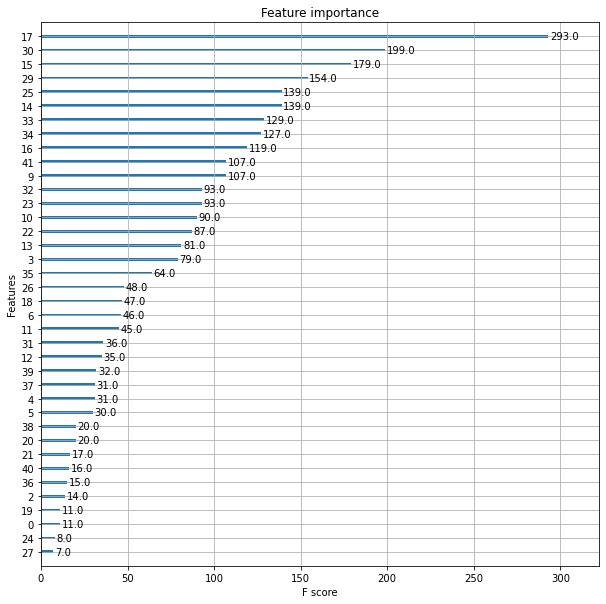

In [128]:
fig , ax = plt.subplots(figsize = (10,10))
plot_importance(xgb_model, ax=ax)
fig.show()

In [ ]:
# print(np.mean(auc_scores))

## 제출 파일 만들기


In [7]:
test_user_id_max = 44998
test_user_id_min = 30000
test_user_number = 14999

In [8]:
id_error = test_err[['user_id','errtype']].values
test_x = np.zeros((test_user_number,42))
for person_idx, err in tqdm(id_error):
    # person_idx - test_user_id_min 위치에 person_idx, errtype에 해당하는 error값을 +1
    test_x[person_idx - test_user_id_min,err - 1] += 1
test_x = test_x.reshape(test_x.shape[0],-1)
print(test_x.shape)

100%|██████████████████████████| 16532648/16532648 [00:15<00:00, 1079829.26it/s]

(14999, 42)


In [ ]:
pred_y_list = []
for model in models:
    pred_y = model.predict(test_x)
    pred_y_list.append(pred_y.reshape(-1,1))
    
pred_ensemble = np.mean(pred_y_list, axis = 0)

In [ ]:
pred_ensemble

In [ ]:
sample_submssion = pd.read_csv('../data/sample_submission.csv')

sample_submssion['problem'] = pred_ensemble.reshape(-1)

sample_submssion.to_csv("../data/dacon_baseline.csv", index = False)
sample_submssion